In [4]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

**Read the data file**

In [5]:
data = pd.read_csv('iris.csv')
data.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [6]:
data.describe()

,sepal.length,sepal.width,petal.length,petal.width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


**Data preprocessing and visualizing**

In [7]:
data['variety'].value_counts()

,count
variety,
Setosa,50
Versicolor,50
Virginica,50


<Axes: ylabel='count'>

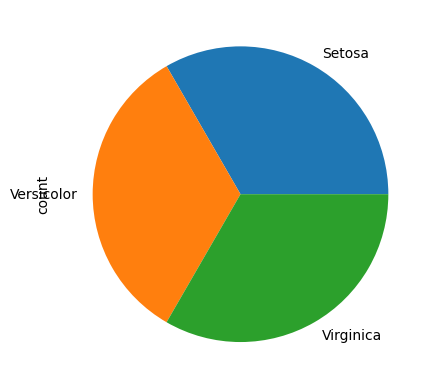

In [8]:
data['variety'].value_counts().plot(kind = 'pie')

In [9]:
data['variety'] = data['variety'].map({'Setosa': 0, 'Versicolor': 1, 'Virginica': 2})
data.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


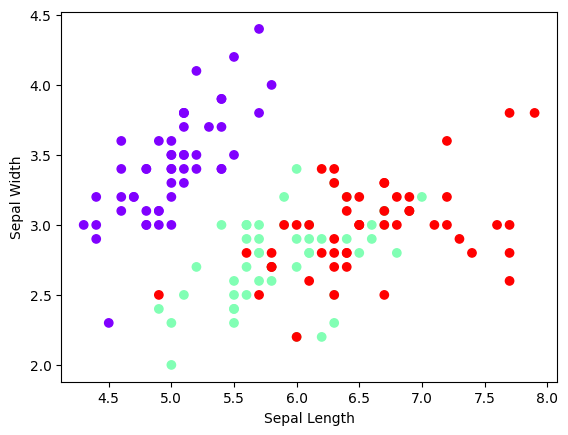

In [10]:
plt.scatter(data['sepal.length'], data['sepal.width'], c = data['variety'], cmap = 'rainbow')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.show()

**Data split into train, validation and test**

In [11]:
x = data.drop('variety', axis = 1)
y = data['variety']

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 1, shuffle = True, stratify = y)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 1, shuffle = True, stratify = y_train)

In [14]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(121, 4)
(14, 4)
(15, 4)


In [15]:
print('Training labels: ', np.bincount(y_train))
print('Validation labels: ',np.bincount(y_val))
print('Testing labels: ',np.bincount(y_test))

Training labels:  [41 40 40]
Validation labels:  [4 5 5]
Testing labels:  [5 5 5]


In [16]:
class MLP(torch.nn.Module):
  def __init__(self, num_features, num_classes):
    super().__init__()
    self.all_layers = torch.nn.Sequential(
        # input layer
        torch.nn.Linear(num_features, 40),
        torch.nn.ReLU(),
        # hidden layer
        torch.nn.Linear(40, 20),
        torch.nn.ReLU(),
        # output layer
        torch.nn.Linear(20, num_classes)
    )

  def forward(self, x):
    logits = self.all_layers(x)
    return logits

In [17]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
   def __init__(self, x, y):

       self.features = torch.tensor(x.values, dtype = torch.float32)
       self.classes = torch.tensor(y.values, dtype = torch.int64)

   def __len__(self):
      return self.classes.shape[0]

   def __getitem__(self, idx):
       x = self.features[idx]
       y = self.classes[idx]
       return x, y

**Define loader**

In [18]:
train_ds = MyDataset(x_train, y_train)
val_ds = MyDataset(x_val, y_val)
test_ds = MyDataset(x_test, y_test)

train_loader = DataLoader(dataset = train_ds, batch_size = 32, shuffle = True)
val_loader = DataLoader(dataset = val_ds, batch_size = 32, shuffle = False)
test_loader = DataLoader(dataset= test_ds, batch_size = 32, shuffle = False)

In [19]:
def compute_accuracy(model, data_loader):
   model = model.eval()

   correct = 0.0
   total = 0

   for idx, (features, classes) in enumerate(data_loader):

          with torch.inference_mode():
               logits = model(features)

          predictions = torch.argmax(logits, dim = 1)

          compare = classes == predictions
          correct += torch.sum(compare)
          total += len(compare)

   return correct / total

In [20]:
torch.manual_seed(1)
model = MLP(num_features = 4,num_classes = 3)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)


In [31]:
num_epochs = 1000

for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, classes) in enumerate(train_loader):

        logits = model(features)
        loss = F.cross_entropy(logits, classes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f'Epoch: {epoch}, Training Accuracy: {train_acc*100:.2f}%, Validation Accuracy: {val_acc*100:.2f}%')

Epoch: 0, Batch: 0, Loss: 0.0180
Epoch: 0, Batch: 1, Loss: 0.0051
Epoch: 0, Batch: 2, Loss: 0.0577
Epoch: 0, Batch: 3, Loss: 0.1198
Epoch: 0, Training Accuracy: 97.52%, Validation Accuracy: 78.57%
Epoch: 1, Batch: 0, Loss: 0.1202
Epoch: 1, Batch: 1, Loss: 0.0151
Epoch: 1, Batch: 2, Loss: 0.0323
Epoch: 1, Batch: 3, Loss: 0.0237
Epoch: 1, Training Accuracy: 98.35%, Validation Accuracy: 85.71%
Epoch: 2, Batch: 0, Loss: 0.1293
Epoch: 2, Batch: 1, Loss: 0.0373
Epoch: 2, Batch: 2, Loss: 0.0026
Epoch: 2, Batch: 3, Loss: 0.0089
Epoch: 2, Training Accuracy: 99.17%, Validation Accuracy: 85.71%
Epoch: 3, Batch: 0, Loss: 0.1374
Epoch: 3, Batch: 1, Loss: 0.0228
Epoch: 3, Batch: 2, Loss: 0.0033
Epoch: 3, Batch: 3, Loss: 0.0390
Epoch: 3, Training Accuracy: 99.17%, Validation Accuracy: 85.71%
Epoch: 4, Batch: 0, Loss: 0.0070
Epoch: 4, Batch: 1, Loss: 0.0441
Epoch: 4, Batch: 2, Loss: 0.0901
Epoch: 4, Batch: 3, Loss: 0.0852
Epoch: 4, Training Accuracy: 97.52%, Validation Accuracy: 85.71%
Epoch: 5, Batch

In [28]:
train_acc = compute_accuracy(model,train_loader)
val_acc = compute_accuracy(model,val_loader)
test_acc = compute_accuracy(model,test_loader)

print(f'Training Accuracy: {train_acc * 100:.2f}%')
print(f'Validation Accuracy: {val_acc * 100:.2f}%')
print(f'Testing Accuracy: {test_acc * 100:.2f}%')

Training Accuracy: 98.35%
Validation Accuracy: 85.71%
Testing Accuracy: 100.00%
